# Setup Environment

In [ ]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import ImageDraw, Image
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
import pandas as pd
from scipy.stats import chisquare
from sklearn.metrics import classification_report, confusion_matrix
from collections import deque, defaultdict
import math

# # Set GPU memory growth to avoid allocating all memory at once
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         # Set GPU memory growth
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         print(f"Found {len(gpus)} GPU devices and enabled memory growth")
#     except RuntimeError as e:
#         print(f"GPU setup error: {e}")

# Setup seeds
SEED = 3888
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
    
# Define constants 
MODELS = ["inceptionv3", "vgg19"] # LIST ALL MODELS HERE
MODEL_DATAGEN = { # ONLY COMPATIBLE WITH KERAS style data gens
    "inceptionv3": ImageDataGenerator(rescale=1./255),
    "vgg19": ImageDataGenerator(rescale=1./255)
}
MODEL_BASE_PATH = os.path.join("model_h5_files") # can add more in here if reqd
# following fns work with imagedatagen:
#  flow_from_directory(dir, target_size, batch_size, Class_mode)
# or flow(x, y, ...)
# and then predict(ImageDataGenerator.flow(), ...)

# THESE CAN BE DYNAMICALLY UPDATED IN A DICT, BUT ARENT FOR NOW 
# in case we want to include a 100x100 in our shiny
IMG_DIM = (224, 224) 
BATCH_SIZE = 32 # will only affect batches for prediction I believe
IMG_SIZE = 224 

# eval
QUADRANTS = ["Q1", "Q2", "Q3", "Q4"]
EVAL_MODEL_PATHS = {
    "Q1": {"inceptionv3": "inceptionV3_Tanvi_fold_1.h5", "vgg19": "VGG19_fold_1.h5"}, # model trained on Q2-Q4
    "Q2": {"inceptionv3": "inceptionV3_Tanvi_fold_2.h5", "vgg19": "VGG19_fold_2.h5"}, # model trained on Q1,Q3,Q4
    "Q3": {"inceptionv3": "inceptionV3_Tanvi_fold_3.h5", "vgg19": "VGG19_fold_3.h5"}, # model trained on Q1,Q2,Q4
    "Q4": {"inceptionv3": "inceptionV3_Tanvi_fold_4.h5", "vgg19": "VGG19_fold_4.h5"} # model trained on Q1-Q3
}
EVALUATION_DATA_PATH = os.path.join("projectdata", "images", "uncentred_ternary_224_ALL")
EVALUATION_IMAGE_PATH =  os.path.join("projectdata", "metadata_code", "GSM7780153_Post-Xenium_HE_Rep1.ome.tif") # path to the big .tif image of all cells

# for deployment
FULL_MODEL_PATH = {"inceptionv3" : "inceptionV3_Tanvi_final.h5", 
                   "vgg19": "VGG19_final.h5"} # FOR DEPLOYMENT ONLY
UPLOADED_IMAGE_PATH = os.path.join("projectdata", "metadata_code", "GSM7780153_Post-Xenium_HE_Rep1.ome.tif") # path to the big .tif image of all cells
MODEL_OUTPUT_MAP = { # models predict numbers, how do we map these to labels?
    # can READ THIS OFF print(classlabels) during model eval
    "inceptionv3": ['Empty', 'Non-Tumor', 'Tumor'], 
    "vgg19": ['Empty', 'Non-Tumor', 'Tumor'] 
}

## Custom Metric Functions

In [ ]:
# NOT USING ANYMORE
def chi_square_test(y_true, y_pred, labels):
    true_counts = np.array([np.sum(y_true == label) for label in labels])
    pred_counts = np.array([np.sum(y_pred == label) for label in labels])
    
    print("True label counts:", true_counts)
    print("Predicted label counts:", pred_counts)
    
    chi2_stat, p_value = chisquare(f_obs=pred_counts, f_exp=true_counts)
    
    print(f"Chi-square statistic = {chi2_stat:.4f}, p-value = {p_value:.4f}")
    
    return chi2_stat, p_value

In [32]:
# UNTESTED
def largest_tumour_mass(grid_IDs, labels):
    # expects grid IDs as [X_coord]_[Y_coord], and label as actual labels
    # does a BFS on grids
    # # Example input: list of (id, label) pairs
    # data = [
    #     ("1_1", "Tumor"),
    #     ("1_2", "Non-Tumor")
    # ]

    # convert to coordinate set, only containing tumour grids
    tumour_coords = set()
    for id_str, label in zip(grid_IDs, labels):
        if label == "Tumor":
            x, y = map(int, id_str.split("_"))
            tumour_coords.add((x, y))

    # BFS to find connected regions
    visited = set()
    directions = [(-1,0), (1,0), (0,-1), (0,1)]  # 4-connected neighborhood

    def bfs(start):
        queue = deque([start])
        region = [start]
        visited.add(start)

        while queue:
            x, y = queue.popleft()
            for dx, dy in directions:
                neighbor = (x + dx, y + dy)
                if neighbor in tumour_coords and neighbor not in visited:
                    visited.add(neighbor)
                    queue.append(neighbor)
                    region.append(neighbor)
        return region

    # find the largest tumour region
    largest_region = []
    for coord in tumour_coords:
        if coord not in visited:
            region = bfs(coord)
            if len(region) > len(largest_region):
                largest_region = region

    return len(largest_region)

In [ ]:
# HEATMAP GENERATION
def box_from_grid_id(grid_ids, image_path, quadrant):
    # this is only for use with training data grid_ids
    # grid ids were defined using entire image coords, BUT STARTING IN BOTTOM RIGHT!!
    # was a weird design chouce
    # so this code will determine pixel coords in original image
    # provides coords RELATIVE TO ENTIRE IMAGE
    
    Image.MAX_IMAGE_PIXELS = None  # Remove limit for large images
    img = Image.open(image_path)
    width, height = img.size
    x_mid, y_mid = width // 2, height // 2
    img.close()
    del img # free up memory

    # RIGHT NOW, as an approximation, this code ISNT considered
    # quadrant_coords = [
    #     (0, 0, x_mid, y_mid),
    #     (width - x_mid, 0, width, y_mid),
    #     (0, height - y_mid, x_mid, height),
    #     (width - x_mid, height - y_mid, width, height)
    #     ]

    # if (quadrant == "Q1"):
    #     quad_box = quadrant_coords[0]
    # elif (quadrant == "Q2"):
    #     quad_box = quadrant_coords[1]
    # elif (quadrant == "Q3"):
    #     quad_box = quadrant_coords[2]
    # elif (quadrant == "Q4"):
    #     quad_box = quadrant_coords[3]
    # else :
    #     raise ValueError("Quadrant must be set appropriately!")

    left_margin = x_mid % IMG_SIZE
    top_margin = y_mid % IMG_SIZE

    coords = []
    for x, y in (map(int, grid_id.split("_")) for grid_id in grid_ids):
        left = left_margin + x * IMG_SIZE
        top = top_margin + y * IMG_SIZE
        coords.append((left, top, left + IMG_SIZE, top + IMG_SIZE))

    return coords



def create_heatmap(image_path, coords, labels, output_path=None, show=True, quadrant=None):
    """
    Create a heatmap overlay on the original image based on grid predictions
    
    Args:
        image_path: Path to the original large image
        coords: List of bounding boxes (left, top, right, bottom) format i think, for each region
        labels: List of corresponding labels for each grid
        output_path: Optional path to save the output image
        show: Whether to display the image
        quadrant: string "Q1", "Q2", "Q3", or "Q4". if not None, will crop big image accordingly
    """
    # Color mapping for labels
    color_map = {
        "Tumor": (1.0, 0.0, 0.0, 0.5),      # Red with 50% transparency
        "Non-Tumor": (0.0, 1.0, 0.0, 0.3),  # Green with 30% transparency
        "Empty": (0.0, 0.0, 1.0, 0.2)       # Blue with 20% transparency
    }
    
    # Load the original image
    Image.MAX_IMAGE_PIXELS = None  # Remove limit for large images
    img = Image.open(image_path)
    width, height = img.size

    # crop if required
    if (quadrant != None):
        x_mid, y_mid = width // 2, height // 2
        quadrant_coords = [
                (0, 0, x_mid, y_mid),
                (width - x_mid, 0, width, y_mid),
                (0, height - y_mid, x_mid, height),
                (width - x_mid, height - y_mid, width, height)
                ]
        
        if (quadrant == "Q1"):
            img = img.crop(quadrant_coords[0]).copy()
            width, height = img.size
        elif (quadrant == "Q2"):
            img = img.crop(quadrant_coords[1]).copy()
            width, height = img.size
        elif (quadrant == "Q3"):
            img = img.crop(quadrant_coords[2]).copy()
            width, height = img.size
        elif (quadrant == "Q4"):
            img = img.crop(quadrant_coords[3]).copy()
            width, height = img.size
        else:
            raise ValueError("Quadrant must be set appropriately, if not none (for whole image heatmap)!")
    
    # Create a transparent overlay
    overlay = Image.new('RGBA', (width, height), (0, 0, 0, 0))

    draw = ImageDraw.Draw(overlay)
    
    # Draw colored rectangles for each grid
    for (left, top, right, bottom), label in zip(coords, labels):
        if label in color_map:
            # Convert RGBA to PIL format (0-255)
            r, g, b, a = color_map[label]
            color = (int(r*255), int(g*255), int(b*255), int(a*255))
            draw.rectangle([left, top, right, bottom], fill=color)
    
    # Convert original image to RGBA
    if img.mode != 'RGBA':
        img = img.convert('RGBA')
    
    # Composite the images
    result = Image.alpha_composite(img, overlay)
    
    if output_path:
        result.save(output_path)
    
    if show:
        plt.figure(figsize=(15, 15))
        plt.imshow(result)
        
        # Create legend
        legend_elements = [plt.Rectangle((0, 0), 1, 1, fc=color_map[label][:3], 
                                            alpha=color_map[label][3], label=label) 
                            for label in color_map]
        plt.legend(handles=legend_elements, loc='upper right')
        plt.axis('off')
        plt.title('Prediction Heatmap')
        plt.show()
    
    img.close()
    del img # free up memory

    return result


def create_comparison_heatmap(image_path, coords, true_labels, pred_labels, 
                                model_name, output_path=None, show=True, quadrant=None):
    """
    Create side-by-side heatmaps comparing true labels vs predicted labels
    
    Args:
        image_path: Path to the original large image
        coords: List of bounding boxes (left, top, right, bottom) format i think, for each region
        true_labels: List of true labels
        pred_labels: List of predicted labels
        model_name: Name of the model for title
        output_path: Optional path to save the output image
        show: Whether to display the image
        quadrant: string "Q1", "Q2", "Q3", or "Q4". if not None, will crop big image accordingly
    """
    plt.figure(figsize=(20, 10))
    
    # True labels heatmap
    plt.subplot(1, 2, 1)
    true_img = create_heatmap(image_path, coords, true_labels, show=False)
    plt.imshow(true_img)
    plt.title(f'True Labels')
    plt.axis('off')
    
    # Predicted labels heatmap
    plt.subplot(1, 2, 2)
    pred_img = create_heatmap(image_path, coords, pred_labels, show=False)
    plt.imshow(pred_img)
    plt.title(f'Predicted Labels ({model_name})')
    plt.axis('off')
    
    # Create legend
    color_map = {
        "Tumor": (1.0, 0.0, 0.0, 0.5),
        "Non-Tumor": (0.0, 1.0, 0.0, 0.3),
        "Empty": (0.0, 0.0, 1.0, 0.2)
    }
    legend_elements = [plt.Rectangle((0, 0), 1, 1, fc=color_map[label][:3], 
                                        alpha=color_map[label][3], label=label) 
                        for label in color_map]
    plt.figlegend(handles=legend_elements, loc='lower center', ncol=3)
    
    plt.suptitle(f'Comparison of True vs Predicted Labels ({model_name})', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    
    if show:
        plt.show()

# Outer Model (Evaluation)

## Generate predictions on quadrants

In [11]:
y_preds = {quadrant: {} for quadrant in QUADRANTS}
y_true = {quadrant: {} for quadrant in QUADRANTS}
classlabels = {quadrant: {} for quadrant in QUADRANTS}
filenames = {quadrant: {} for quadrant in QUADRANTS}  # maps each prediction to a grid id (based on filename)

for quadrant in QUADRANTS:
    test_dir = os.path.join(EVALUATION_DATA_PATH, quadrant)

    for model_name in MODELS:
        model = load_model(os.path.join(MODEL_BASE_PATH, EVAL_MODEL_PATHS[quadrant][model_name]))
        datagen = MODEL_DATAGEN[model_name] # this is a function

        test_gen = datagen.flow_from_directory(
            test_dir, target_size=IMG_DIM, batch_size=BATCH_SIZE,
            class_mode='categorical', shuffle=False
        )

            
        test_preds = model.predict(test_gen)

        y_preds[quadrant].update({model_name : np.argmax(test_preds, axis=1)})
        y_true[quadrant].update({model_name : test_gen.classes})
        classlabels[quadrant].update({model_name : list(test_gen.class_indices.keys())})
        filenames[quadrant].update({model_name : test_gen.filenames})

Found 1004 images belonging to 3 classes.
32/32 [==============================] - 20s 594ms/step
Found 1004 images belonging to 3 classes.
32/32 [==============================] - 98s 3s/step
Found 1174 images belonging to 3 classes.
37/37 [==============================] - 30s 797ms/step
Found 1174 images belonging to 3 classes.
37/37 [==============================] - 118s 3s/step
Found 1739 images belonging to 3 classes.
55/55 [==============================] - 46s 814ms/step
Found 1739 images belonging to 3 classes.
55/55 [==============================] - 182s 3s/step
Found 2000 images belonging to 3 classes.
63/63 [==============================] - 63s 983ms/step
Found 2000 images belonging to 3 classes.
63/63 [==============================] - 198s 3s/step


In [33]:
print(y_preds)
print(y_true)
print(classlabels)
print(filenames)

{'Q1': {'inceptionv3': array([1, 1, 1, ..., 1, 2, 1], dtype=int64), 'vgg19': array([1, 1, 0, ..., 2, 2, 1], dtype=int64)}, 'Q2': {'inceptionv3': array([1, 1, 1, ..., 1, 2, 2], dtype=int64), 'vgg19': array([1, 1, 1, ..., 1, 2, 2], dtype=int64)}, 'Q3': {'inceptionv3': array([0, 2, 0, ..., 2, 2, 1], dtype=int64), 'vgg19': array([0, 0, 0, ..., 1, 2, 1], dtype=int64)}, 'Q4': {'inceptionv3': array([1, 1, 1, ..., 1, 1, 2], dtype=int64), 'vgg19': array([1, 1, 1, ..., 1, 2, 2], dtype=int64)}}
{'Q1': {'inceptionv3': array([0, 0, 0, ..., 2, 2, 2]), 'vgg19': array([0, 0, 0, ..., 2, 2, 2])}, 'Q2': {'inceptionv3': array([0, 0, 0, ..., 2, 2, 2]), 'vgg19': array([0, 0, 0, ..., 2, 2, 2])}, 'Q3': {'inceptionv3': array([0, 0, 0, ..., 2, 2, 2]), 'vgg19': array([0, 0, 0, ..., 2, 2, 2])}, 'Q4': {'inceptionv3': array([0, 0, 0, ..., 2, 2, 2]), 'vgg19': array([0, 0, 0, ..., 2, 2, 2])}}
{'Q1': {'inceptionv3': ['Empty', 'Non-Tumor', 'Tumor'], 'vgg19': ['Empty', 'Non-Tumor', 'Tumor']}, 'Q2': {'inceptionv3': ['Emp

### Can observe performance, but note this is not for final report -> doesnt consider full training data, only testing data for outer model

In [13]:
for quadrant in QUADRANTS:
    for model_name in MODELS:
        print(f"{model_name} on {quadrant}")
        print(classification_report(y_true[quadrant][model_name], y_preds[quadrant][model_name], target_names=classlabels[quadrant][model_name]))
        print(confusion_matrix(y_true[quadrant][model_name], y_preds[quadrant][model_name]))
        print("--------")

inceptionv3 on Q1
              precision    recall  f1-score   support

       Empty       0.67      0.03      0.05        75
   Non-Tumor       0.73      0.99      0.84       618
       Tumor       0.98      0.52      0.68       311

    accuracy                           0.77      1004
   macro avg       0.79      0.51      0.52      1004
weighted avg       0.80      0.77      0.73      1004

[[  2  73   0]
 [  1 613   4]
 [  0 149 162]]
--------
vgg19 on Q1
              precision    recall  f1-score   support

       Empty       0.75      0.16      0.26        75
   Non-Tumor       0.76      0.94      0.84       618
       Tumor       0.84      0.60      0.70       311

    accuracy                           0.78      1004
   macro avg       0.78      0.57      0.60      1004
weighted avg       0.78      0.78      0.75      1004

[[ 12  61   2]
 [  4 581  33]
 [  0 123 188]]
--------
inceptionv3 on Q2
              precision    recall  f1-score   support

       Empty       0.38  

## Generate results from predictions

### Numerical

In [44]:
# should be populated in same order as MODELS list is defined
# each list per model, holds results for each quadrant
print(MODELS) # THIS IS THE ORDER OF RESULTS, FOR EACH QUADRANT

results = {
    'quadrant': [], # ID col
    'model': [], # ID col
    # true val
    'number_tumour_grids_true': [],
    'number_nontumour_grids_true': [],
    'number_empty_grids_true': [],
    'percent_tumour_true': [],
    'largest_mass_true': [],
    # pred val
    'number_tumour_grids_pred': [],
    'number_nontumour_grids_pred': [],
    'number_empty_grids_pred': [],
    'percent_tumour_pred': [],
    'largest_mass_pred': [],
}

['inceptionv3', 'vgg19']


In [ ]:
for quadrant in QUADRANTS:
    for model_name in MODELS:
        preds = [classlabels[quadrant][model_name][i] for i in y_preds[quadrant][model_name]] 
        true = [classlabels[quadrant][model_name][i] for i in y_true[quadrant][model_name]] 

        # filanames of form - 'Empty\\grid_39_34_224.png'
        grid_ids = ["_".join(name.split("_")[1:3]) for name in filenames[quadrant][model_name]] 

        results['quadrant'].append(quadrant)
        results['model'].append(model_name)

        results['number_tumour_grids_true'].append(true.count("Tumor"))
        results['number_nontumour_grids_true'].append(true.count("Non-Tumor"))
        results['number_empty_grids_true'].append(true.count("Empty"))
        results['percent_tumour_true'].append((true.count("Tumor")/len(true))*100)
        results['largest_mass_true'].append(largest_tumour_mass(grid_ids, true))

        results['number_tumour_grids_pred'].append(preds.count("Tumor"))
        results['number_nontumour_grids_pred'].append(preds.count("Non-Tumor"))
        results['number_empty_grids_pred'].append(preds.count("Empty"))
        results['percent_tumour_pred'].append((preds.count("Tumor")/len(preds))*100)
        results['largest_mass_pred'].append(largest_tumour_mass(grid_ids, preds))

results_df = pd.DataFrame(results)
print(results_df.head())

  quadrant        model  number_tumour_grids_true  \
0       Q1  inceptionv3                       311   
1       Q1        vgg19                       311   
2       Q2  inceptionv3                       268   
3       Q2        vgg19                       268   
4       Q3  inceptionv3                      1271   

   number_nontumour_grids_true  number_empty_grids_true  percent_tumour_true  \
0                          618                       75            30.976096   
1                          618                       75            30.976096   
2                          736                      170            22.827939   
3                          736                      170            22.827939   
4                          438                       30            73.087982   

   largest_mass_true  number_tumour_grids_pred  number_nontumour_grids_pred  \
0                249                       166                          835   
1                249                      

### Graphical

model inceptionv3 quadrant Q1 HEATMAP


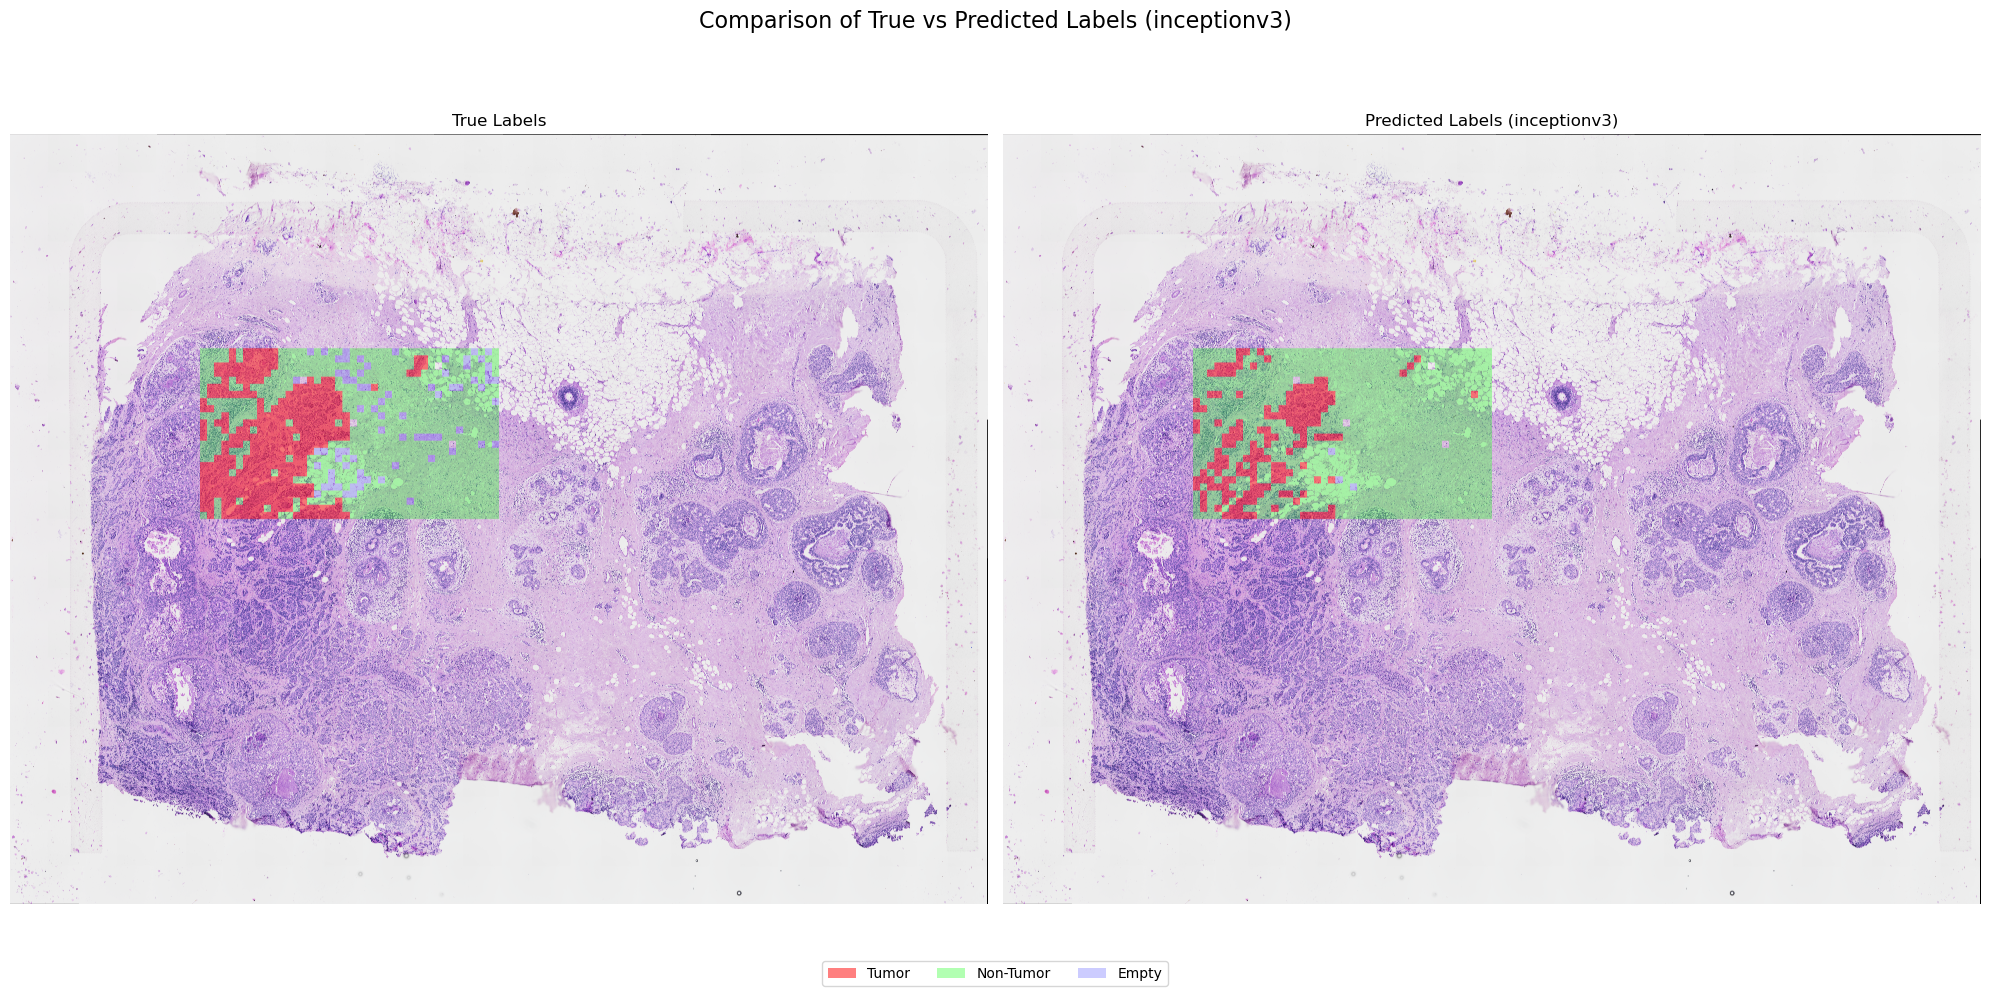

-------------
model vgg19 quadrant Q1 HEATMAP


KeyboardInterrupt: 

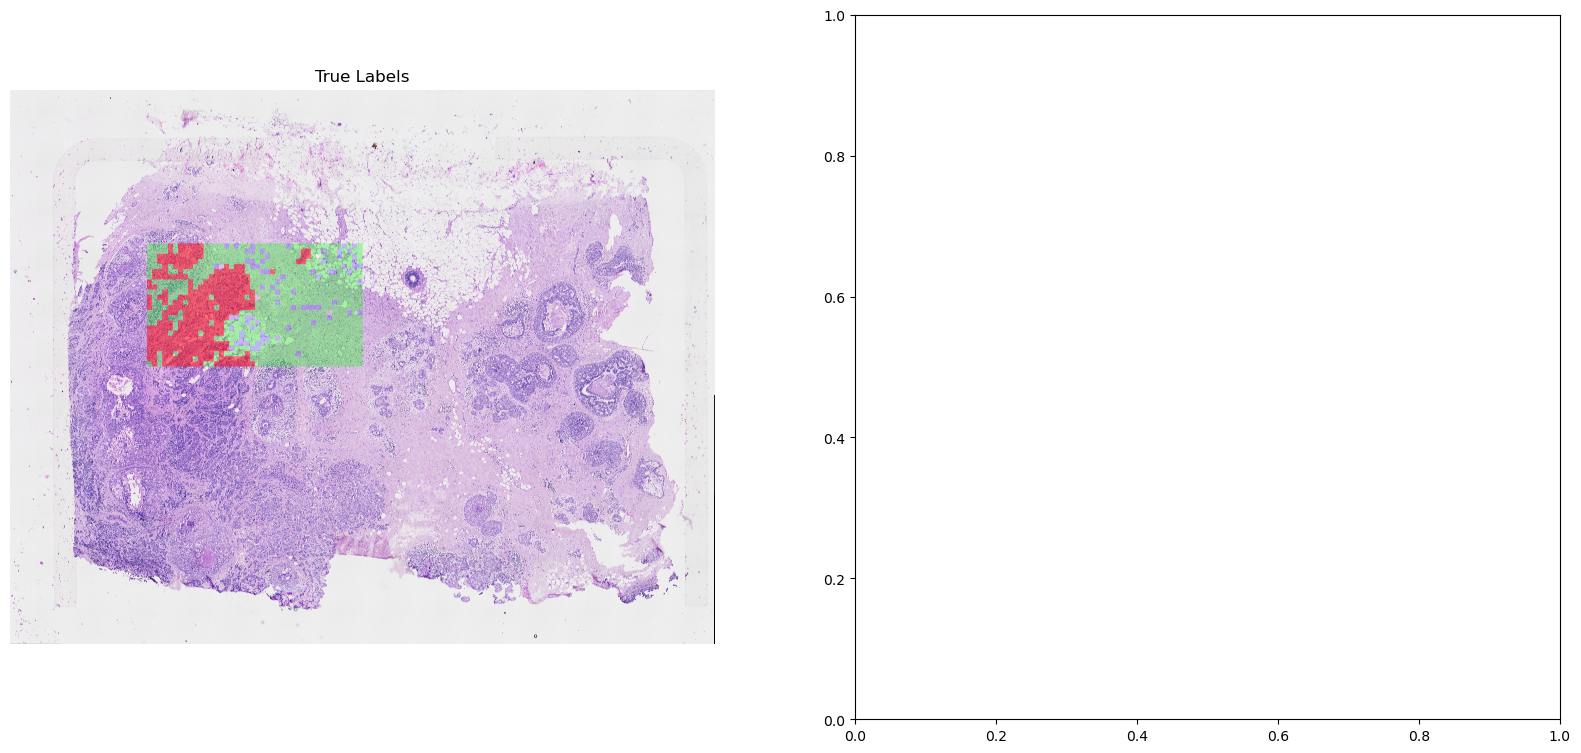

In [59]:
for quadrant in QUADRANTS:
    for model_name in MODELS:
        print(f"model {model_name} quadrant {quadrant} HEATMAP")
        grid_ids = ["_".join(name.split("_")[1:3]) for name in filenames[quadrant][model_name]] 

        preds = [classlabels[quadrant][model_name][i] for i in y_preds[quadrant][model_name]] 
        true = [classlabels[quadrant][model_name][i] for i in y_true[quadrant][model_name]] 

        create_comparison_heatmap(EVALUATION_IMAGE_PATH, box_from_grid_id(grid_ids, EVALUATION_IMAGE_PATH, quadrant), 
                                  true, preds, model_name, quadrant=quadrant)
        print("-------------")

C:\Users\Yash Agarwal\AppData\Local\Temp\ipykernel_40804\641844203.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')


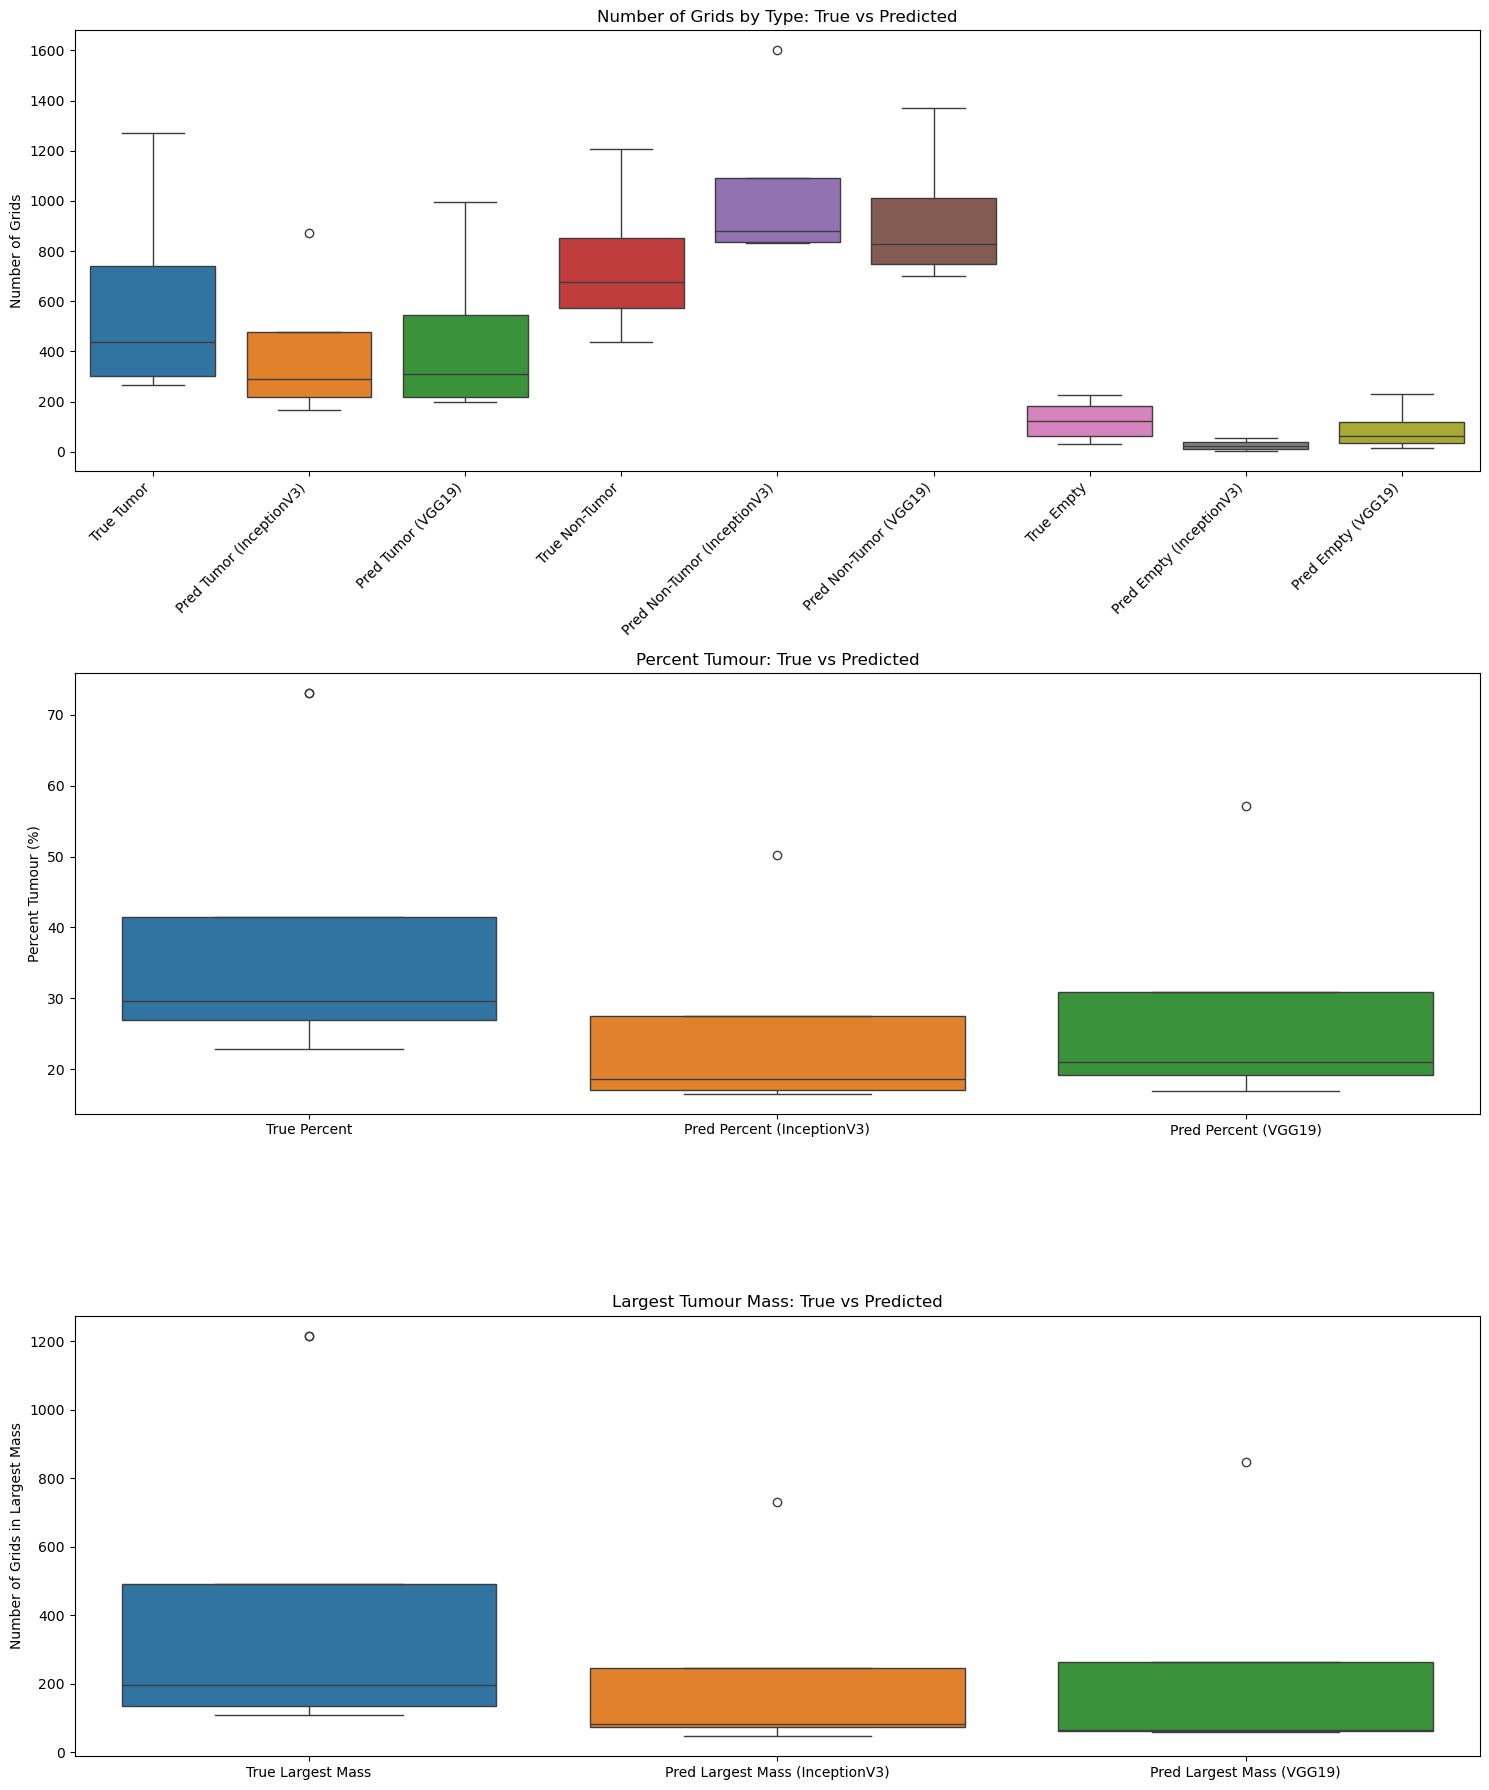

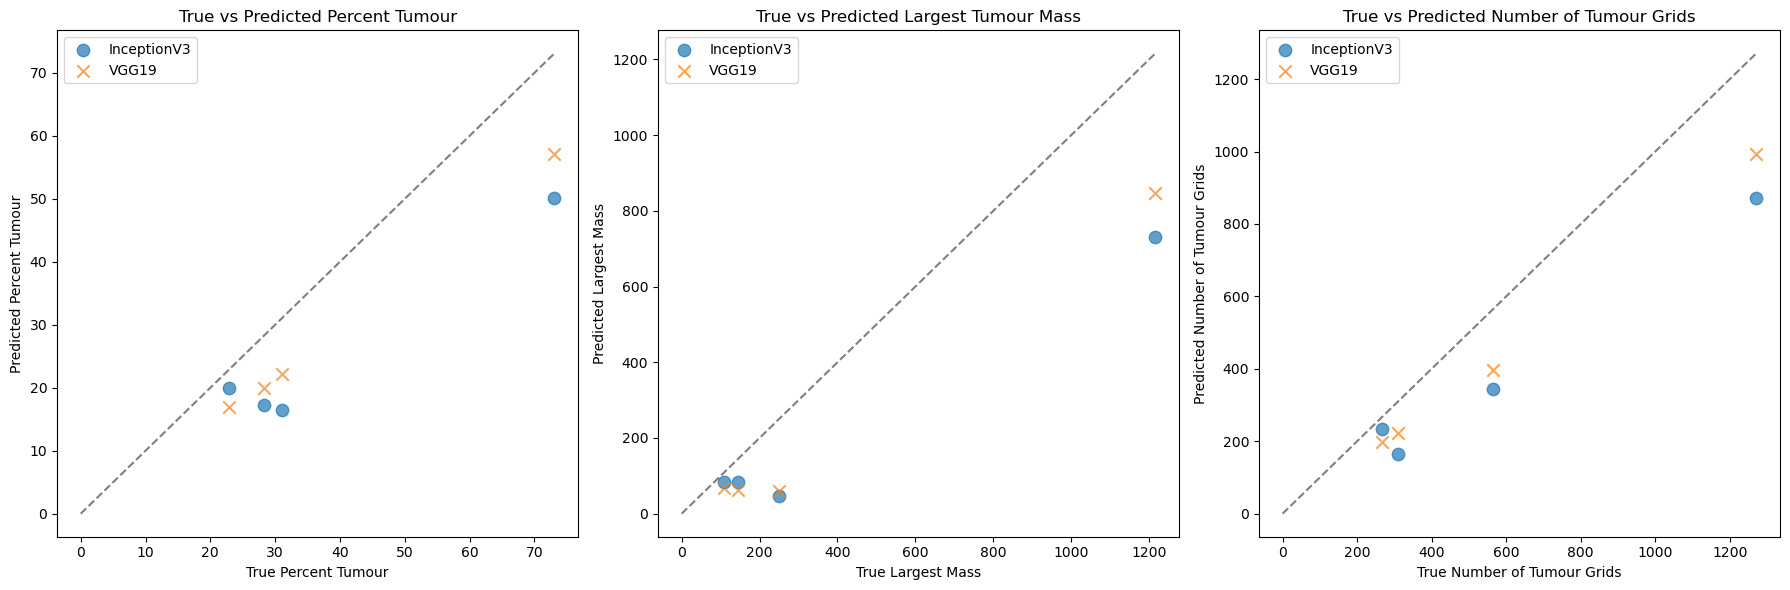

In [ ]:
# Create 3 plots comparing predicted vs true values for both models
fig, axes = plt.subplots(3, 1, figsize=(15, 18))

# Plot 1: Box plots for number of grids by type
# Prepare data for the first plot
grid_types = ['Tumor', 'Non-Tumor', 'Empty']
grid_data = {
    'True Tumor': results_df['number_tumour_grids_true'],
    'Pred Tumor (InceptionV3)': results_df[results_df['model'] == 'inceptionv3']['number_tumour_grids_pred'],
    'Pred Tumor (VGG19)': results_df[results_df['model'] == 'vgg19']['number_tumour_grids_pred'],
    'True Non-Tumor': results_df['number_nontumour_grids_true'],
    'Pred Non-Tumor (InceptionV3)': results_df[results_df['model'] == 'inceptionv3']['number_nontumour_grids_pred'],
    'Pred Non-Tumor (VGG19)': results_df[results_df['model'] == 'vgg19']['number_nontumour_grids_pred'],
    'True Empty': results_df['number_empty_grids_true'],
    'Pred Empty (InceptionV3)': results_df[results_df['model'] == 'inceptionv3']['number_empty_grids_pred'],
    'Pred Empty (VGG19)': results_df[results_df['model'] == 'vgg19']['number_empty_grids_pred']
}

# Create box plot for grid counts
sns.boxplot(data=grid_data, ax=axes[0])
axes[0].set_title('Number of Grids by Type: True vs Predicted (DO NOT USE THIS FOR REPORT, THIS SHOULD BE TAKEN FROM INNER MODEL SCRIPTS)')
axes[0].set_ylabel('Number of Grids')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

# Plot 2: Box plots for percent tumour
percent_data = {
    'True Percent': results_df['percent_tumour_true'],
    'Pred Percent (InceptionV3)': results_df[results_df['model'] == 'inceptionv3']['percent_tumour_pred'],
    'Pred Percent (VGG19)': results_df[results_df['model'] == 'vgg19']['percent_tumour_pred']
}

sns.boxplot(data=percent_data, ax=axes[1])
axes[1].set_title('Percent Tumour: True vs Predicted')
axes[1].set_ylabel('Percent Tumour (%)')

# Plot 3: Box plots for largest mass
mass_data = {
    'True Largest Mass': results_df['largest_mass_true'],
    'Pred Largest Mass (InceptionV3)': results_df[results_df['model'] == 'inceptionv3']['largest_mass_pred'],
    'Pred Largest Mass (VGG19)': results_df[results_df['model'] == 'vgg19']['largest_mass_pred']
}

sns.boxplot(data=mass_data, ax=axes[2])
axes[2].set_title('Largest Tumour Mass: True vs Predicted')
axes[2].set_ylabel('Number of Grids in Largest Mass')

plt.tight_layout()
plt.show()

# Also create a scatter plot to compare true vs predicted for both models
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Prepare data by model
inception_df = results_df[results_df['model'] == 'inceptionv3']
vgg_df = results_df[results_df['model'] == 'vgg19']

# Plot scatter for percent tumour
axes[0].scatter(inception_df['percent_tumour_true'], inception_df['percent_tumour_pred'], 
               label='InceptionV3', marker='o', s=80, alpha=0.7)
axes[0].scatter(vgg_df['percent_tumour_true'], vgg_df['percent_tumour_pred'], 
               label='VGG19', marker='x', s=80, alpha=0.7)
# Add perfect prediction line
max_val = max(results_df['percent_tumour_true'].max(), results_df['percent_tumour_pred'].max())
axes[0].plot([0, max_val], [0, max_val], 'k--', alpha=0.5)
axes[0].set_xlabel('True Percent Tumour')
axes[0].set_ylabel('Predicted Percent Tumour')
axes[0].set_title('True vs Predicted Percent Tumour')
axes[0].legend()

# Plot scatter for largest mass
axes[1].scatter(inception_df['largest_mass_true'], inception_df['largest_mass_pred'], 
               label='InceptionV3', marker='o', s=80, alpha=0.7)
axes[1].scatter(vgg_df['largest_mass_true'], vgg_df['largest_mass_pred'], 
               label='VGG19', marker='x', s=80, alpha=0.7)
# Add perfect prediction line
max_val = max(results_df['largest_mass_true'].max(), results_df['largest_mass_pred'].max())
axes[1].plot([0, max_val], [0, max_val], 'k--', alpha=0.5)
axes[1].set_xlabel('True Largest Mass')
axes[1].set_ylabel('Predicted Largest Mass')
axes[1].set_title('True vs Predicted Largest Tumour Mass')
axes[1].legend()

# Plot scatter for number of tumour grids
axes[2].scatter(inception_df['number_tumour_grids_true'], inception_df['number_tumour_grids_pred'], 
               label='InceptionV3', marker='o', s=80, alpha=0.7)
axes[2].scatter(vgg_df['number_tumour_grids_true'], vgg_df['number_tumour_grids_pred'], 
               label='VGG19', marker='x', s=80, alpha=0.7)
# Add perfect prediction line
max_val = max(results_df['number_tumour_grids_true'].max(), results_df['number_tumour_grids_pred'].max())
axes[2].plot([0, max_val], [0, max_val], 'k--', alpha=0.5)
axes[2].set_xlabel('True Number of Tumour Grids')
axes[2].set_ylabel('Predicted Number of Tumour Grids')
axes[2].set_title('True vs Predicted Number of Tumour Grids')
axes[2].legend()

plt.tight_layout()
plt.show()

## Performance metrics

In [68]:
# # inner model perf (classification style)
# acc = []
# f1 = []
# confusion = []

# outer model perf (regression style)
# rmse_grid_distributions = []
rmse_percent_tumour = []
rmse_largest_mass = [] 
rmse_number_tumour_grids = []



outer_performance = {
    'model': [], # ID col
    #"rmse_grid_distributions" : [],
    "rmse_percent_tumour" : [],
    "rmse_largest_mass" : [] ,
    "rmse_number_tumour_grids" : []
}

Model Performance Metrics (aggregated across quadrants):
         model  rmse_percent_tumour  rmse_largest_mass  \
0  inceptionv3            14.687321         265.292292   
1        vgg19            10.426087         211.915667   
2  inceptionv3            14.687321         265.292292   
3        vgg19            10.426087         211.915667   

   rmse_number_tumour_grids  
0                239.492171  
1                171.116189  
2                239.492171  
3                171.116189  


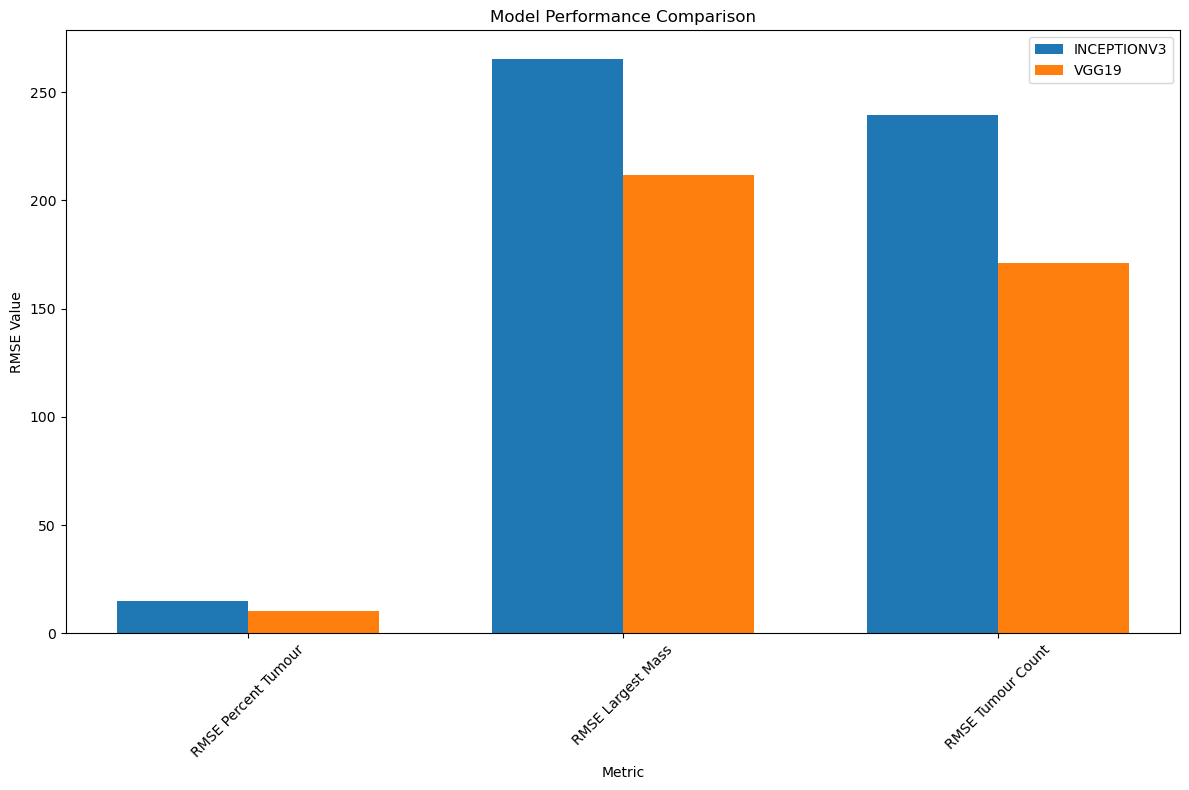

In [70]:
# Calculate RMSE for various metrics
for model_name in MODELS:
    # Filter results by model
    model_results = results_df[results_df['model'] == model_name]
    
    # # Calculate RMSE for grid distributions (sum of squared differences for all grid types)
    # grid_dist_squared_diff = (
    #     (model_results['number_tumour_grids_true'] - model_results['number_tumour_grids_pred'])**2 +
    #     (model_results['number_nontumour_grids_true'] - model_results['number_nontumour_grids_pred'])**2 +
    #     (model_results['number_empty_grids_true'] - model_results['number_empty_grids_pred'])**2
    # )
    # rmse_grid_dist = np.sqrt(grid_dist_squared_diff.mean())
    
    # Calculate RMSE for percent tumour
    rmse_percent = np.sqrt(((model_results['percent_tumour_true'] - model_results['percent_tumour_pred'])**2).mean())
    
    # Calculate RMSE for largest mass
    rmse_mass = np.sqrt(((model_results['largest_mass_true'] - model_results['largest_mass_pred'])**2).mean())
    
    # Calculate RMSE for number of tumour grids
    rmse_tumour_count = np.sqrt(((model_results['number_tumour_grids_true'] - model_results['number_tumour_grids_pred'])**2).mean())
    
    # Store results in the performance dictionary
    outer_performance['model'].append(model_name)
    #outer_performance['rmse_grid_distributions'].append(rmse_grid_dist)
    outer_performance['rmse_percent_tumour'].append(rmse_percent)
    outer_performance['rmse_largest_mass'].append(rmse_mass) 
    outer_performance['rmse_number_tumour_grids'].append(rmse_tumour_count)

# Convert to DataFrame for better visualization
performance_df = pd.DataFrame(outer_performance)

# Display the performance metrics
print("Model Performance Metrics (aggregated across quadrants):")
print(performance_df)

# Create a bar chart to compare model performance
plt.figure(figsize=(12, 8))
metrics = ['rmse_percent_tumour', 'rmse_largest_mass', 'rmse_number_tumour_grids'] # 'rmse_grid_distributions', 
metric_names = ['RMSE Percent Tumour', 'RMSE Largest Mass', 'RMSE Tumour Count'] #' RMSE Grid Distribution', 

bar_width = 0.35
x = np.arange(len(metrics))

for i, model in enumerate(MODELS):
    model_data = performance_df[performance_df['model'] == model]
    values = [model_data[metric].values[0] for metric in metrics]
    plt.bar(x + i*bar_width, values, bar_width, label=model.upper())

plt.xlabel('Metric')
plt.ylabel('RMSE Value')
plt.title('Model Performance Comparison')
plt.xticks(x + bar_width/2, metric_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# # chi-squared
# i = 1
# for dist in grid_distribution:
#     print(f"Chi-square test for Q{i}")
#     chi_square_test(result['y_true'], result['y_pred'])
#     print("\n")
#     i += 1

Chi-square test for Q1
True label counts: [503 447 100]
Predicted label counts: [425 525 100]
Chi-square statistic = 25.7062, p-value = 0.0000


Chi-square test for Q2
True label counts: [503 387 100]
Predicted label counts: [430 456 104]
Chi-square statistic = 23.0568, p-value = 0.0000


Chi-square test for Q3
True label counts: [503 500 100]
Predicted label counts: [395 620  88]
Chi-square statistic = 53.4289, p-value = 0.0000


Chi-square test for Q4
True label counts: [503 500 100]
Predicted label counts: [470 515 118]
Chi-square statistic = 5.8550, p-value = 0.0535




# Outer Model (Deployment)

## Split uploaded image into patches

In [71]:
# remove the limit for large images 
Image.MAX_IMAGE_PIXELS = None  

# open image
big_image = Image.open(UPLOADED_IMAGE_PATH)
width, height = big_image.size

In [72]:
# store coord of each grid sqaure, relative to the entire big image
grids = []
boxes = []

for i in range(width, 0, -IMG_SIZE):
    for j in range(height, 0, -IMG_SIZE):
        # REVERSE ORDER was used when producing grid squares for training/testing, so this is maintained here

        # define the box for cropping, (left, top, right, bottom)
        box = (i - IMG_SIZE, j - IMG_SIZE, i, j)
        
        # ignore boxes that are too close to the edges (just a failsafe)
        if box[0] < 0 or box[1] < 0:
            continue
        
        # save copies, in case behind the scenes it saves the big image + a crop coord (online sources suggested this could happen)
        grids.append(big_image.crop(box).copy())
        boxes.append(box)

print(len(grids))
print((width*height)/(IMG_SIZE**2))

14796
14873.314453125


In [73]:
big_image.close()
del big_image # free up memory

## Generate predictions on big image

In [78]:
y_preds = {}

for model_name in MODELS:
    model = load_model(os.path.join(MODEL_BASE_PATH, EVAL_MODEL_PATHS[quadrant][model_name]))
    datagen = MODEL_DATAGEN[model_name] # this is a function

    # convert list of PIL images to NumPy array, for prediction
    X = np.stack([np.array(img) for img in grids]).astype('float32') 
    # Now create generator
    deploy_gen = datagen.flow(
        x = X, y = [0 for i in range(len(grids))], # dummy labels,
        batch_size=BATCH_SIZE, shuffle=False
    )
  
    test_preds = model.predict(deploy_gen)
    y_preds.update({model_name : np.argmax(test_preds, axis=1)})

463/463 [==============================] - 1429s 3s/step


In [79]:
print(y_preds)

{'inceptionv3': array([0, 0, 0, ..., 0, 0, 1], dtype=int64), 'vgg19': array([0, 0, 0, ..., 0, 0, 0], dtype=int64)}


## Generate results from predictions

In [83]:
results = {
    'model': [], # ID col
    # pred val
    'number_tumour_grids_pred': [],
    'number_nontumour_grids_pred': [],
    'number_empty_grids_pred': [],
    'percent_tumour_pred': [],
    'largest_mass_pred': [],
}

In [84]:
for model_name in MODELS:
    preds = [MODEL_OUTPUT_MAP[model_name][i] for i in y_preds[model_name]] 

    # for largest mass
    grid_ids = [str(math.floor(box[0]/IMG_SIZE)) + "_" + str(math.floor(box[1]/IMG_SIZE)) for box in boxes]

    results['model'].append(model_name)

    results['number_tumour_grids_pred'].append(preds.count("Tumor"))
    results['number_nontumour_grids_pred'].append(preds.count("Non-Tumor"))
    results['number_empty_grids_pred'].append(preds.count("Empty"))
    results['percent_tumour_pred'].append((preds.count("Tumor")/len(preds))*100)
    results['largest_mass_pred'].append(largest_tumour_mass(grid_ids, preds))

results_df = pd.DataFrame(results)
print(results_df.head())

         model  number_tumour_grids_pred  number_nontumour_grids_pred  \
0  inceptionv3                      8023                         4437   
1        vgg19                      6297                         5933   

   number_empty_grids_pred  percent_tumour_pred  largest_mass_pred  
0                     2336            54.224115               6837  
1                     2566            42.558800               5361  


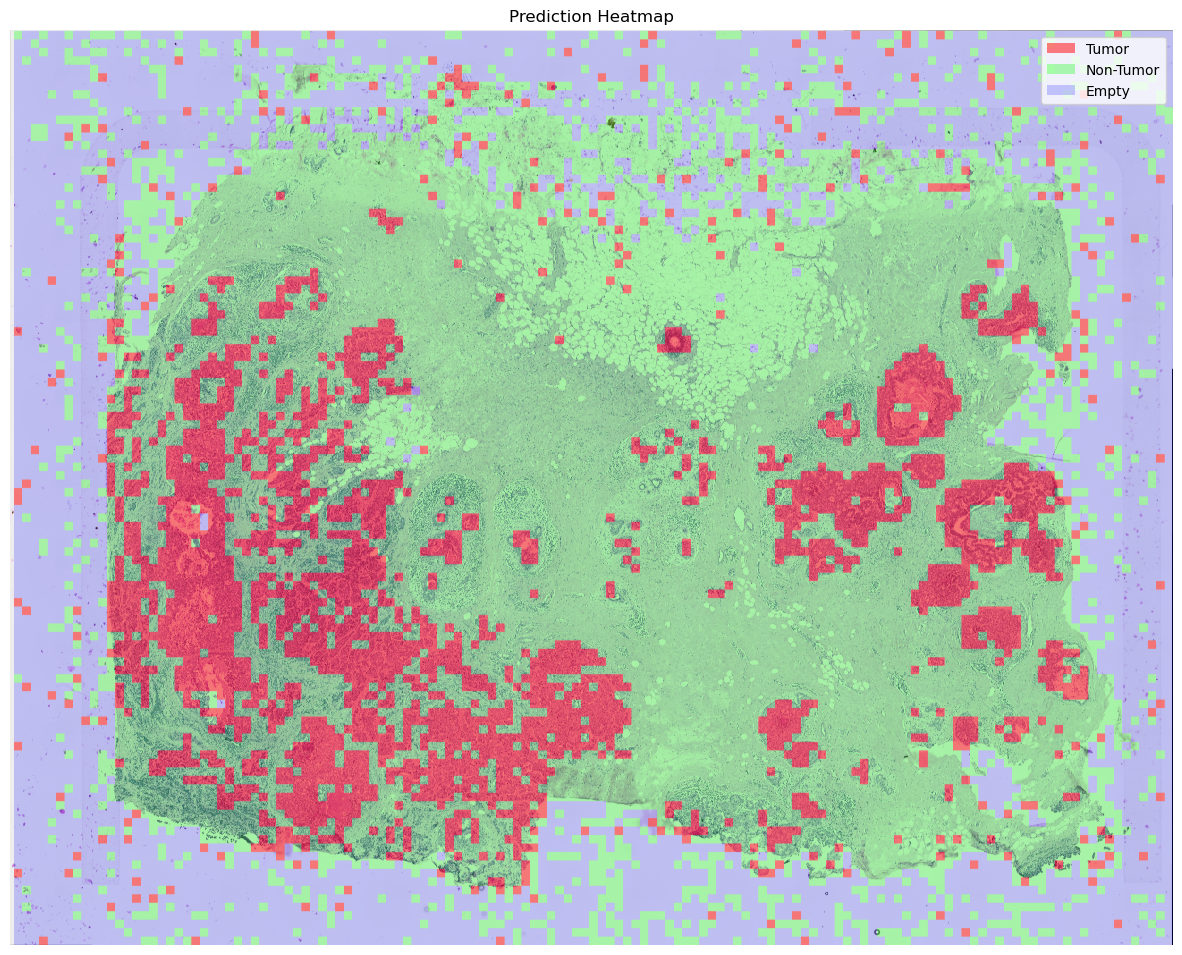

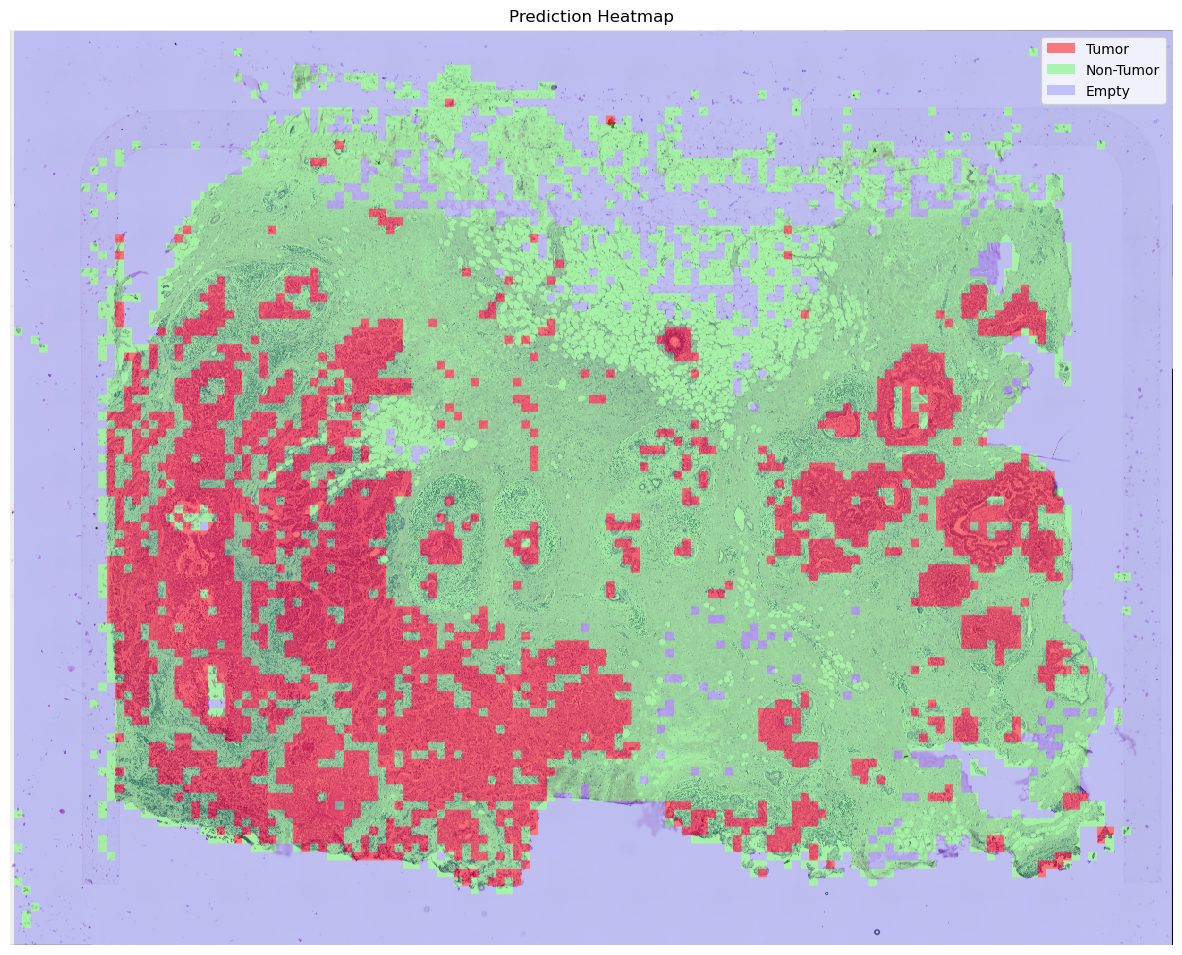

In [93]:
for model_name in MODELS:
    preds = [MODEL_OUTPUT_MAP[model_name][i] for i in y_preds[model_name]] 
    create_heatmap(UPLOADED_IMAGE_PATH, boxes, preds)

C:\Users\Yash Agarwal\AppData\Local\Temp\ipykernel_40804\92647464.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')


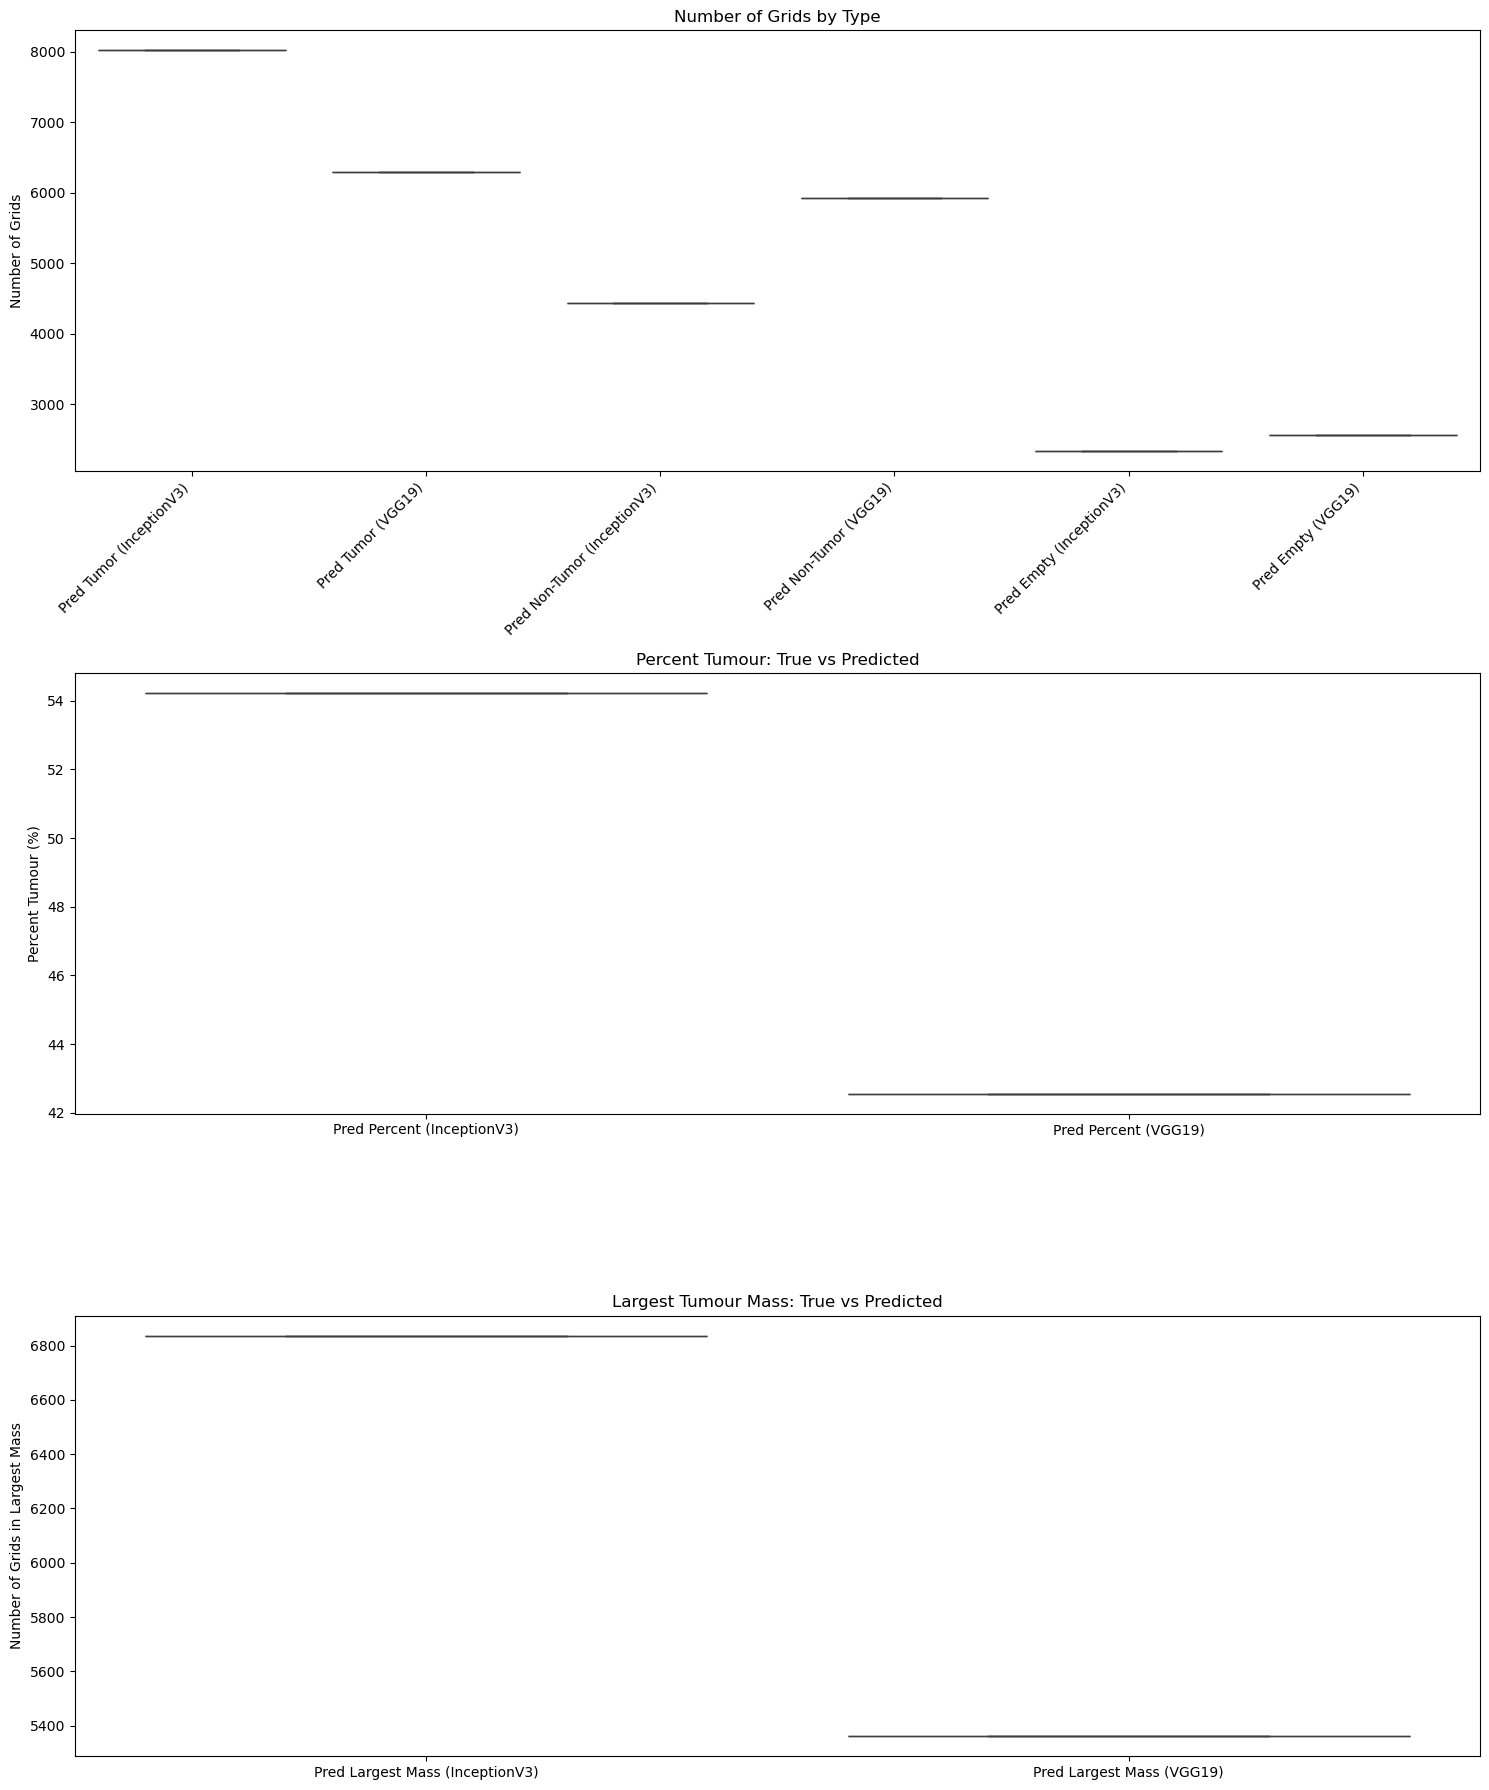

In [ ]:
# Create 3 plots comparing predicted vs true values for both models
fig, axes = plt.subplots(3, 1, figsize=(15, 18))

# Plot 1: Box plots for number of grids by type
# Prepare data for the first plot
grid_types = ['Tumor', 'Non-Tumor', 'Empty']
grid_data = {
    'Pred Tumor (InceptionV3)': results_df[results_df['model'] == 'inceptionv3']['number_tumour_grids_pred'],
    'Pred Tumor (VGG19)': results_df[results_df['model'] == 'vgg19']['number_tumour_grids_pred'],
    'Pred Non-Tumor (InceptionV3)': results_df[results_df['model'] == 'inceptionv3']['number_nontumour_grids_pred'],
    'Pred Non-Tumor (VGG19)': results_df[results_df['model'] == 'vgg19']['number_nontumour_grids_pred'],
    'Pred Empty (InceptionV3)': results_df[results_df['model'] == 'inceptionv3']['number_empty_grids_pred'],
    'Pred Empty (VGG19)': results_df[results_df['model'] == 'vgg19']['number_empty_grids_pred']
}

# Create box plot for grid counts
sns.boxplot(data=grid_data, ax=axes[0])
axes[0].set_title('Number of Grids by Type')
axes[0].set_ylabel('Number of Grids')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

# Plot 2: Box plots for percent tumour
percent_data = {
    'Pred Percent (InceptionV3)': results_df[results_df['model'] == 'inceptionv3']['percent_tumour_pred'],
    'Pred Percent (VGG19)': results_df[results_df['model'] == 'vgg19']['percent_tumour_pred']
}

sns.boxplot(data=percent_data, ax=axes[1])
axes[1].set_title('Percent Tumour')
axes[1].set_ylabel('Percent Tumour (%)')

# Plot 3: Box plots for largest mass
mass_data = {
    'Pred Largest Mass (InceptionV3)': results_df[results_df['model'] == 'inceptionv3']['largest_mass_pred'],
    'Pred Largest Mass (VGG19)': results_df[results_df['model'] == 'vgg19']['largest_mass_pred']
}

sns.boxplot(data=mass_data, ax=axes[2])
axes[2].set_title('Largest Tumour Mass')
axes[2].set_ylabel('Number of Grids in Largest Mass')

plt.tight_layout()
plt.show()